In [61]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer ,BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import spacy
import torch.nn as nn
import torch.optim as optim
from torch.hub import load
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsRegressor





In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load dataset
file_path = 'full_format_recipes.json' 
data = pd.read_json(file_path)
data.dropna(inplace=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)



In [4]:

# Basic exploration
print(f"Dataset shape: {data.shape}")
print("Columns:", data.columns)

Dataset shape: (10608, 11)
Columns: Index(['directions', 'fat', 'date', 'categories', 'calories', 'desc',
       'protein', 'rating', 'title', 'ingredients', 'sodium'],
      dtype='object')


In [5]:
# Focus on relevant columns
StringData = data[['directions', 'desc', 'rating','categories','title']].copy()

StringDataWithNames=data[['directions', 'desc', 'rating','categories','title']].copy()






In [6]:
# Handle nested structures and add column names before each value
string_columns = ['directions', 'categories', 'desc', 'title']

for col in string_columns:
    StringDataWithNames[col] = StringDataWithNames[col].apply(
        lambda x: f"{col}: {', '.join(map(str, x))}" if isinstance(x, (list, np.ndarray)) else f"{col}: {x}" if pd.notnull(x) else x
    )

# Ensure all values are strings before concatenation
StringDataWithNames['Alltext'] = StringDataWithNames['directions'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
) + " " + StringDataWithNames['categories'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
) + " " + StringDataWithNames['desc'].apply(
    lambda x: str(x)
) + " " + StringDataWithNames['title'].apply(
    lambda x: str(x)
)




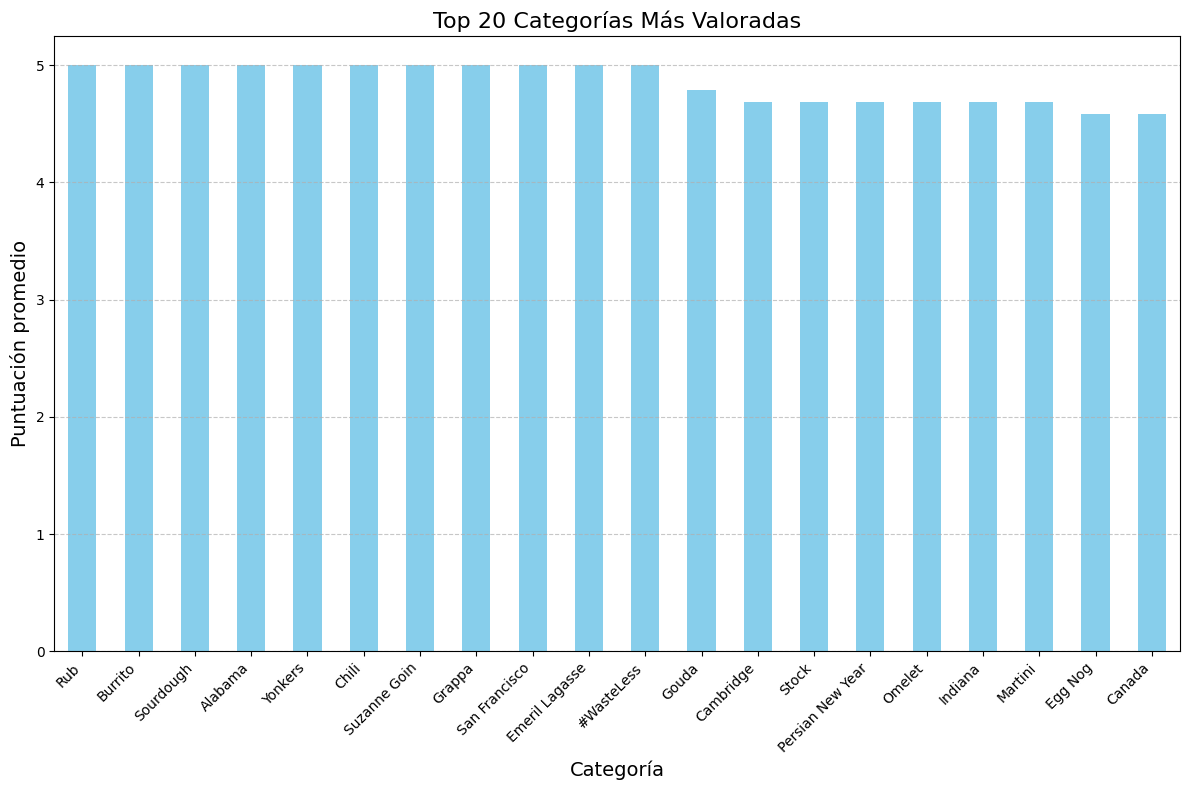

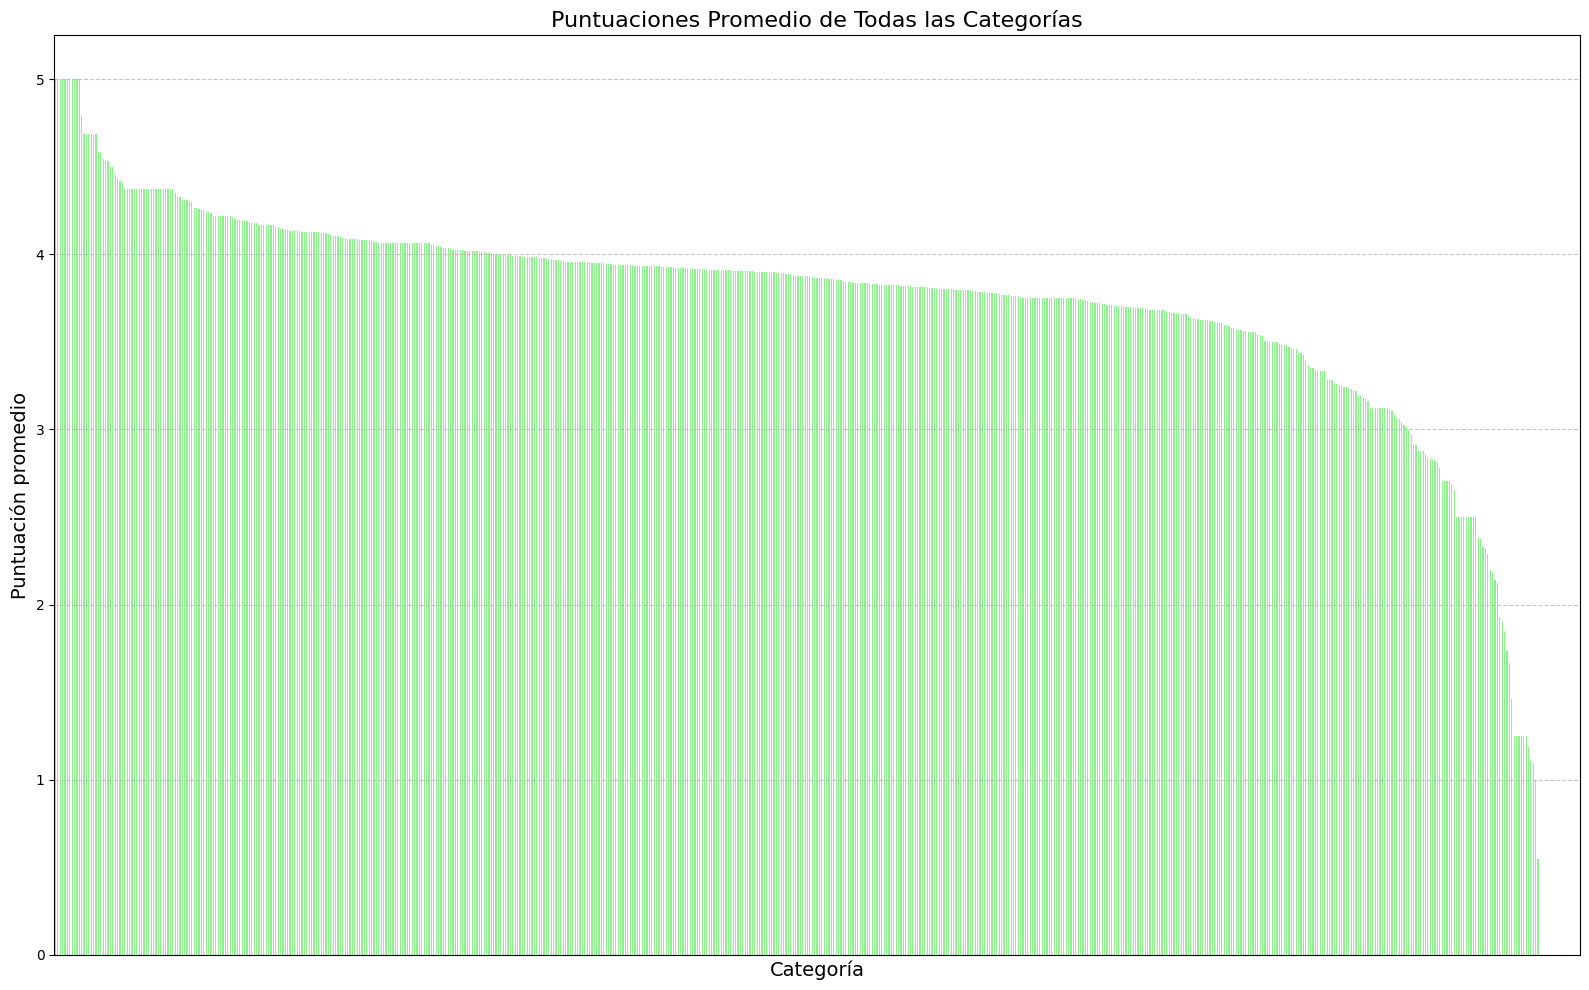

Número total de categorías únicas: 637


In [7]:


# Explode the 'categories' column and calculate mean ratings for each category
categories_exploded = data.explode('categories')
category_ratings = categories_exploded.groupby('categories')['rating'].mean().sort_values(ascending=False)

# Plot the top 20 categories
plt.figure(figsize=(12, 8))
category_ratings.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Categorías Más Valoradas', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot all categories without x-axis labels
plt.figure(figsize=(16, 10))
category_ratings.plot(kind='bar', color='lightgreen')
plt.title('Puntuaciones Promedio de Todas las Categorías', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks([])  # Removes x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the total number of unique categories
categorias_unicas = categories_exploded['categories'].nunique()
print(f"Número total de categorías únicas: {categorias_unicas}")




In [8]:
# Text preprocessing function
nlp = spacy.load('en_core_web_sm')
def preprocess_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])


In [9]:


# Apply preprocessing
StringData['processed_directions'] = StringData['directions'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_desc'] = StringData['desc'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_categories'] = StringData['categories'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_title'] = StringData['title'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))







In [10]:
# Extract and normalize numeric features
numeric_features = data[['fat', 'protein', 'calories', 'sodium']]
scaler = StandardScaler()
numeric_features = scaler.fit_transform(numeric_features)

In [11]:
print(StringData[['processed_directions', 'processed_desc', 'processed_categories', 'processed_title']].head())

                                processed_directions  \
0  simmer pea cream red pepper flake garlic teasp...   
1  Combine sugar orange juice concentrate water h...   
2  preheat oven F Butter flour cup Bundt pan Whis...   
3  heat peanut oil heavy large pot medium high he...   
4  stir ingredient small bowl blend season taste ...   

                                      processed_desc  \
0  zing fresh lemon enhance pea sweetness natural...   
1           Orange syrup sweeten cake fresh fruit go   
2  brandied whip cream add perfect finishing touc...   
3  hearty stew like soup inspire vietnamese pho h...   
4                                 nice toasted bagel   

                                processed_categories  \
0  Milk Cream Pasta Christmas Vegetarian Quick Ea...   
1  chocolate Dessert Bake Passover Orange Date Wa...   
2  Cake Fruit Dessert Currant Orange Pineapple Al...   
3  Soup Stew Beef Sauté Dinner Lunch Spring Noodl...   
4  Condiment Spread Dairy fish Herb Breakfast 

--------------------------------------------------------------------TF-IDF------------------------------------------------------------------

In [12]:
# TF-IDF vectorization for individual columns
vectorizer = TfidfVectorizer(max_features=100)
categories_tfidf = vectorizer.fit_transform(StringData['processed_categories'])
desc_tfidf = vectorizer.fit_transform(StringData['processed_desc'])
directions_tfidf = vectorizer.fit_transform(StringData['processed_directions'])
title_tfidf = vectorizer.fit_transform(StringData['processed_title'])

In [13]:
#Convert data to X and Y combining numeric and written features
X_TFIDF = torch.tensor(
    pd.concat(
        [pd.DataFrame(categories_tfidf.toarray()), pd.DataFrame(desc_tfidf.toarray()), pd.DataFrame(directions_tfidf.toarray()), pd.DataFrame(title_tfidf.toarray()), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [14]:
# Train-test-validation split
X_train_TFIDF, X_test_TFIDF, y_train, y_test = train_test_split(
   X_TFIDF, y, test_size=0.2, random_state=42)

X_val_TFIDF, X_test_TFIDF, y_val, y_test = train_test_split(
    X_test_TFIDF, y_test, test_size=0.5, random_state=42)  

--------------------------------------------------------------------WORD2VEC------------------------------------------------------------------

In [15]:
# Prepare data for Word2Vec
documents = StringData['processed_directions'].tolist() + StringData['processed_desc'].tolist() + \
            StringData['processed_categories'].tolist() + StringData['processed_title'].tolist()
tokenized_documents = [doc.split() for doc in documents]



In [16]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_documents, vector_size=100, window=5, min_count=1, workers=4)

In [17]:
# Function to calculate document embeddings
def get_doc_embedding(doc, model):
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [18]:

# Generate Word2Vec embeddings for each column
StringData['directions_w2v'] = StringData['processed_directions'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['desc_w2v'] = StringData['processed_desc'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['categories_w2v'] = StringData['processed_categories'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['title_w2v'] = StringData['processed_title'].apply(lambda x: get_doc_embedding(x, word2vec_model))


In [19]:

# Combine Word2Vec embeddings into a single feature matrix
w2v_features = np.array(StringData['directions_w2v'].tolist()) + \
               np.array(StringData['desc_w2v'].tolist()) + \
               np.array(StringData['categories_w2v'].tolist()) + \
               np.array(StringData['title_w2v'].tolist())


In [20]:
#Convert data to X and Y combining numeric and written features
X_W2V = torch.tensor(
    pd.concat(
        [pd.DataFrame(w2v_features), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

#
# final_features = np.hstack([w2v_features, numeric_features])


In [21]:
# Train-test split
X_train_W2V, X_test_W2V, y_train, y_test = train_test_split(
   X_W2V, y, test_size=0.2, random_state=42)
X_val_W2V, X_test_W2V, y_val, y_test = train_test_split(
    X_test_W2V, y_test, test_size=0.5, random_state=42)  

--------------------------------------------------------------------BERT------------------------------------------------------------------

In [22]:

# Using BERT embeddings for contextual embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [23]:
def get_bert_embeddings(text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, max_length=64, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    # Use the CLS token embeddings as the document representation
    return outputs.last_hidden_state[:, 0, :].numpy()



In [24]:
#X_text_Prebert = StringDataWithNames['Alltext']
#X_embeddings = get_bert_embeddings(X_text_Prebert.tolist())
embeddings_directions = get_bert_embeddings(StringDataWithNames['directions'].tolist())
embeddings_desc = get_bert_embeddings(StringDataWithNames['desc'].tolist())
embeddings_categories = get_bert_embeddings(StringDataWithNames['categories'].tolist())
embeddings_title = get_bert_embeddings(StringDataWithNames['title'].tolist())

# Stack all features together
X_embeddings = np.hstack([
    embeddings_directions,
    embeddings_desc,
    embeddings_categories,
    embeddings_title,
    numeric_features
])





In [25]:
# Combine BERT embeddings and numeric features
X_BERT = torch.tensor(
    pd.concat(
        [pd.DataFrame(X_embeddings), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [26]:
# Split BERT
X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    X_BERT, y, test_size=0.2, random_state=42)

X_val_bert, X_test_bert, y_val, y_test = train_test_split(
    X_test_bert, y_test, test_size=0.5, random_state=42)

-----------------------------------------------------------------------------Before Starting---------------------------------------------------------------------

In [27]:

# Calculate the mean of the 'rating' feature
mean_rating = StringData['rating'].mean()

# Create a prediction array with the mean value for all samples
predictions = np.full_like(StringData['rating'], mean_rating)

# Calculate the MAE
mae = mean_absolute_error(StringData['rating'], predictions)

print(f"Mean rating: {mean_rating}")
print(f"MAE when predicting the mean: {mae}")

Mean rating: 3.8045578808446456
MAE when predicting the mean: 0.828418629242508


--------------------------------------------------------------------KNN------------------------------------------------------------------

In [28]:

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_TFIDF, y_train)

KNeighborsRegressor()

In [29]:
# Ensure X_test and y_test are numpy arrays
#X_test_bert_np = X_train_bert.cpu().numpy() if isinstance(X_train_bert, torch.Tensor) else X_train_bert
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_TFIDF)
print("KNN MSE:", mean_squared_error(y_test, knn_predictions))
print("KNN MAE:", mean_absolute_error(y_test, knn_predictions))

KNN MSE: 1.562175989151001
KNN MAE: 0.8282281160354614


In [30]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_W2V, y_train)

KNeighborsRegressor()

In [31]:
# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_W2V)
print("KNN MSE:", mean_squared_error(y_test, knn_predictions))
print("KNN MAE:",  mean_absolute_error(y_test, knn_predictions))


KNN MSE: 1.5123556852340698
KNN MAE: 0.8175070881843567


In [32]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_bert, y_train)


KNeighborsRegressor()

In [33]:

# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_bert)
print("KNN MSE:", mean_squared_error(y_test_np, knn_predictions))
print("KNN MAE:",  mean_absolute_error(y_test,knn_predictions))


KNN MSE: 1.4450842142105103
KNN MAE: 0.7875824570655823


--------------------------------------------------------------------SIMPLE NN------------------------------------------------------------------

----------------------------------------------------------------------SIMPLE NN WITH W2V-----------------------------------------------------------

In [34]:
# Train a neural network using PyTorch
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)



In [35]:
input_size = X_train_W2V.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_W2V).float().to(device) if isinstance(X_train_W2V, np.ndarray) else X_train_W2V.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_W2V).float().to(device) if isinstance(X_val_W2V, np.ndarray) else X_val_W2V.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_W2V).float().to(device) if isinstance(X_test_W2V, np.ndarray) else X_test_W2V.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [37]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 200  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")



Epoch 1, Training Loss: 3.9780473709106445, Validation Loss: 3.7959516048431396
Epoch 2, Training Loss: 3.748155355453491, Validation Loss: 3.574799060821533
Epoch 3, Training Loss: 3.534576654434204, Validation Loss: 3.360020160675049
Epoch 4, Training Loss: 3.3283138275146484, Validation Loss: 3.1470680236816406
Epoch 5, Training Loss: 3.123992681503296, Validation Loss: 2.934018850326538
Epoch 6, Training Loss: 2.920152187347412, Validation Loss: 2.720355987548828
Epoch 7, Training Loss: 2.7162208557128906, Validation Loss: 2.505629539489746
Epoch 8, Training Loss: 2.51164174079895, Validation Loss: 2.290287733078003
Epoch 9, Training Loss: 2.3053553104400635, Validation Loss: 2.0751993656158447
Epoch 10, Training Loss: 2.0971686840057373, Validation Loss: 1.8601634502410889
Epoch 11, Training Loss: 1.8880295753479004, Validation Loss: 1.6526787281036377
Epoch 12, Training Loss: 1.6817190647125244, Validation Loss: 1.456572413444519
Epoch 13, Training Loss: 1.487019419670105, Valida

In [38]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")



Neural Network Test Loss: 0.7466778755187988
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.4806922674179077
 - Mean Absolute Error (MAE): 0.7466778755187988


----------------------------------------------------------------------SIMPLE NN WITH TFIDF-----------------------------------------------------------

In [39]:
input_size = X_train_TFIDF.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_TFIDF).float().to(device) if isinstance(X_train_TFIDF, np.ndarray) else X_train_TFIDF.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_TFIDF).float().to(device) if isinstance(X_val_TFIDF, np.ndarray) else X_val_TFIDF.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_TFIDF).float().to(device) if isinstance(X_test_TFIDF, np.ndarray) else X_test_TFIDF.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [41]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 200  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")

Epoch 1, Training Loss: 3.7335054874420166, Validation Loss: 3.7452592849731445
Epoch 2, Training Loss: 3.697950601577759, Validation Loss: 3.7082364559173584
Epoch 3, Training Loss: 3.6619040966033936, Validation Loss: 3.670473575592041
Epoch 4, Training Loss: 3.625164031982422, Validation Loss: 3.631732702255249
Epoch 5, Training Loss: 3.5874931812286377, Validation Loss: 3.5917909145355225
Epoch 6, Training Loss: 3.548658609390259, Validation Loss: 3.5504567623138428
Epoch 7, Training Loss: 3.508798360824585, Validation Loss: 3.5075128078460693
Epoch 8, Training Loss: 3.4673187732696533, Validation Loss: 3.4628803730010986
Epoch 9, Training Loss: 3.4241654872894287, Validation Loss: 3.4165191650390625
Epoch 10, Training Loss: 3.3792831897735596, Validation Loss: 3.368379831314087
Epoch 11, Training Loss: 3.3326354026794434, Validation Loss: 3.318431854248047
Epoch 12, Training Loss: 3.28420090675354, Validation Loss: 3.26662015914917
Epoch 13, Training Loss: 3.233959674835205, Valid

In [42]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7620027661323547
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.4336432218551636
 - Mean Absolute Error (MAE): 0.7620027661323547


----------------------------------------------------------------------SIMPLE NN WITH BERT-----------------------------------------------------------

In [43]:
input_size = X_train_bert.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_bert).float().to(device) if isinstance(X_train_bert, np.ndarray) else X_train_bert.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_bert).float().to(device) if isinstance(X_val_bert, np.ndarray) else X_val_bert.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_bert).float().to(device) if isinstance(X_test_bert, np.ndarray) else X_test_bert.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [45]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 500  # Number of epochs to wait before stopping
tolerance = 1e-5  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")

Epoch 1, Training Loss: 3.6616322994232178, Validation Loss: 1.7122294902801514
Epoch 2, Training Loss: 1.7226943969726562, Validation Loss: 0.8964409828186035
Epoch 5, Training Loss: 0.9584174752235413, Validation Loss: 0.8483321666717529
Epoch 9, Training Loss: 0.9022894501686096, Validation Loss: 0.7542340159416199
Epoch 10, Training Loss: 0.7939797043800354, Validation Loss: 0.9653981924057007
Epoch 20, Training Loss: 0.8996508717536926, Validation Loss: 0.7809164524078369
Epoch 21, Training Loss: 0.8255364894866943, Validation Loss: 0.7452086210250854
Epoch 26, Training Loss: 0.8048340678215027, Validation Loss: 0.742231547832489
Epoch 29, Training Loss: 0.8186962008476257, Validation Loss: 0.7382807731628418
Epoch 30, Training Loss: 0.7762730121612549, Validation Loss: 0.7414876222610474
Epoch 35, Training Loss: 0.7784914970397949, Validation Loss: 0.7317639589309692
Epoch 38, Training Loss: 0.7803620100021362, Validation Loss: 0.730582594871521
Epoch 40, Training Loss: 0.7712725

In [46]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7290480136871338
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.4130182266235352
 - Mean Absolute Error (MAE): 0.7290480732917786


------------------------------------------------------------------------COMPLEX MODEL------------------------------------------------------------------

----------------------------------------------------------------------COMPLEX NN WITH W2V-----------------------------------------------------------

In [47]:


class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=None, dropout_rate=0.3):
        super(ComplexNN, self).__init__()
        
        if hidden_sizes is None:
            hidden_sizes = [256, 128, 64]  # Default hidden layer sizes
        
        layers = []
        in_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            in_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        # Define the sequential model
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(x)





In [48]:
input_size = X_train_W2V.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [49]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_W2V).float().to(device) if isinstance(X_train_W2V, np.ndarray) else X_train_W2V.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_W2V).float().to(device) if isinstance(X_val_W2V, np.ndarray) else X_val_W2V.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_W2V).float().to(device) if isinstance(X_test_W2V, np.ndarray) else X_test_W2V.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [50]:


# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.8280599117279053, Validation Loss: 3.8265271186828613
Epoch 2, Training Loss: 3.8013792037963867, Validation Loss: 3.808098077774048
Epoch 3, Training Loss: 3.800886392593384, Validation Loss: 3.786893367767334
Epoch 4, Training Loss: 3.788487195968628, Validation Loss: 3.767085552215576
Epoch 5, Training Loss: 3.7805938720703125, Validation Loss: 3.743950843811035
Epoch 6, Training Loss: 3.765629291534424, Validation Loss: 3.722346305847168
Epoch 7, Training Loss: 3.7688844203948975, Validation Loss: 3.698237180709839
Epoch 8, Training Loss: 3.753272294998169, Validation Loss: 3.6731648445129395
Epoch 9, Training Loss: 3.7462050914764404, Validation Loss: 3.6486127376556396
Epoch 10, Training Loss: 3.7434322834014893, Validation Loss: 3.6255125999450684
Epoch 11, Training Loss: 3.7281155586242676, Validation Loss: 3.6050097942352295
Epoch 12, Training Loss: 3.721773624420166, Validation Loss: 3.586301565170288
Epoch 13, Training Loss: 3.7220637798309326, Vali

In [51]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")


Neural Network Test Loss: 0.6931620836257935
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.313618779182434
 - Mean Absolute Error (MAE): 0.6931620836257935


----------------------------------------------------------------------COMPLEX NN WITH TFIDF-----------------------------------------------------------

In [52]:
input_size = X_train_TFIDF.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [53]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_TFIDF).float().to(device) if isinstance(X_train_TFIDF, np.ndarray) else X_train_TFIDF.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_TFIDF).float().to(device) if isinstance(X_val_TFIDF, np.ndarray) else X_val_TFIDF.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_TFIDF).float().to(device) if isinstance(X_test_TFIDF, np.ndarray) else X_test_TFIDF.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [54]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6 # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.848740816116333, Validation Loss: 3.8446264266967773
Epoch 2, Training Loss: 3.8228893280029297, Validation Loss: 3.8353755474090576
Epoch 3, Training Loss: 3.804910182952881, Validation Loss: 3.8222098350524902
Epoch 4, Training Loss: 3.799349069595337, Validation Loss: 3.8052310943603516
Epoch 5, Training Loss: 3.7839417457580566, Validation Loss: 3.7859439849853516
Epoch 6, Training Loss: 3.7807366847991943, Validation Loss: 3.7680599689483643
Epoch 7, Training Loss: 3.7754437923431396, Validation Loss: 3.7524755001068115
Epoch 8, Training Loss: 3.7595317363739014, Validation Loss: 3.7388501167297363
Epoch 9, Training Loss: 3.7564384937286377, Validation Loss: 3.7260611057281494
Epoch 10, Training Loss: 3.742035150527954, Validation Loss: 3.714242935180664
Epoch 11, Training Loss: 3.7376487255096436, Validation Loss: 3.707778215408325
Epoch 12, Training Loss: 3.7258107662200928, Validation Loss: 3.704444408416748
Epoch 13, Training Loss: 3.7162020206451416,

In [55]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.669069766998291
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.2543779611587524
 - Mean Absolute Error (MAE): 0.6690698266029358


----------------------------------------------------------------------COMPLEX NN WITH BERT-----------------------------------------------------------

In [56]:
input_size = X_train_bert.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [57]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_bert).float().to(device) if isinstance(X_train_bert, np.ndarray) else X_train_bert.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_bert).float().to(device) if isinstance(X_val_bert, np.ndarray) else X_val_bert.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_bert).float().to(device) if isinstance(X_test_bert, np.ndarray) else X_test_bert.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [58]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.7918665409088135, Validation Loss: 3.755706787109375
Epoch 2, Training Loss: 3.754636764526367, Validation Loss: 3.7158758640289307
Epoch 3, Training Loss: 3.736924171447754, Validation Loss: 3.703237771987915
Epoch 10, Training Loss: 3.6868977546691895, Validation Loss: 3.911555290222168
Epoch 20, Training Loss: 3.5850844383239746, Validation Loss: 3.6986162662506104
Epoch 21, Training Loss: 3.582108736038208, Validation Loss: 3.6718926429748535
Epoch 22, Training Loss: 3.567688465118408, Validation Loss: 3.6511855125427246
Epoch 23, Training Loss: 3.5641579627990723, Validation Loss: 3.641273021697998
Epoch 24, Training Loss: 3.545508623123169, Validation Loss: 3.6360788345336914
Epoch 25, Training Loss: 3.5414633750915527, Validation Loss: 3.6200177669525146
Epoch 30, Training Loss: 3.455709218978882, Validation Loss: 3.7293269634246826
Epoch 40, Training Loss: 3.2936763763427734, Validation Loss: 3.5635533332824707
Epoch 41, Training Loss: 3.27829933166503

In [60]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7099319100379944
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.3403396606445312
 - Mean Absolute Error (MAE): 0.7099319696426392


------------------------------------------------------------------------FINE TUNNING FROM HUGGING FACE--------------------------------------------------------------------------

In [69]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:


# Split the encodings
train_text, test_text, train_labels, test_labels = train_test_split(
    StringDataWithNames['desc'].tolist(), StringDataWithNames['rating'].tolist(),test_size=0.2,random_state=42)

Train_encodings = tokenizer(train_text,truncation=True, padding=True, max_length=128)
Test_encodings = tokenizer(test_text,truncation=True, padding=True, max_length=128)




In [76]:

train_labels = [int(label) for label in train_labels]
test_labels = [int(label) for label in test_labels]



In [74]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val
        in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = Dataset(Train_encodings, train_labels)
test_dataset = Dataset(Test_encodings, test_labels)

In [77]:
training_args = TrainingArguments(
output_dir='./results', # Directorio de salida
num_train_epochs=3, # Epocas
per_device_train_batch_size=16, # Batch entrenamiento
per_device_eval_batch_size=64, # Batch evaluacion
warmup_steps=500, # Steps de calentamiento↪→
weight_decay=0.01, # Decaimiento del peso↪→
logging_dir='./logs', # Directorio de logs↪→
logging_steps=10,
)

trainer = Trainer(
model=model, # Modelo preentrenado↪→
args=training_args, # Argumentos de entrenamiento↪→
train_dataset=train_dataset, # Datos de entrenamiento↪→
eval_dataset=test_dataset # Datos de evaluacion↪→
)
# Iniciar el fine-tuning
trainer.train()

  0%|          | 0/1593 [00:00<?, ?it/s]

ValueError: Target size (torch.Size([16])) must be the same as input size (torch.Size([16, 2]))

In [ ]:

trainer.evaluate()
# Guardar el modelo fine-tuned
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')